In [11]:
import re
from pathlib import Path
from datetime import datetime

def _read_data(path):
    base_path = Path(path)
    console_logs = []
    message_logs = []
    
    # Process console logs
    for file_path in (base_path / "console").glob("*"):
        with file_path.open(errors='replace') as f:
            for line in f:
                parsed = parse_console_log(line.strip())
                if parsed is None:
                    continue
                console_logs.append(parsed)
    
    # Process message logs
    for file_path in (base_path / "message").glob("*"):
        with file_path.open(errors='replace') as f:
            for line in f:
                parsed = parse_message_log(line.strip())
                if parsed is not None:  # Added None check for consistency
                    message_logs.append(parsed)
    
    return combine_and_sort_logs(console_logs, message_logs)

def parse_console_log(line: str):
    parts = line.strip().split(' ', 2)
    if len(parts) < 3:
        return None
    timestamp, hostname, message = parts
    
    # Check if hostname matches c0-* pattern using regex
    if not re.match(r'^c0-.*', hostname):
        return None
    
    return hostname, timestamp, message

def parse_message_log(line: str):
    parts = line.strip().split(' ', 6)
    if len(parts) < 6:
        return None  # Changed from raise to return None for consistency
    timestamp = parts[1]
    hostname = parts[2]
    message = parts[6]
    
    # Check if hostname matches c0-* pattern using regex
    if not re.match(r'^c0-.*', hostname):
        return None
    
    return hostname, timestamp, message

def combine_and_sort_logs(console_logs, message_logs):
    all_logs = [log for log in console_logs + message_logs if log is not None]
    
    # Sort by timestamp (index 1)
    def get_timestamp(item):
        try:
            return datetime.fromisoformat(item[1]).timestamp()
        except ValueError:
            return 0  # Default value if timestamp parsing fails
    
    all_logs_sorted = sorted(all_logs, key=lambda x: get_timestamp(x))
    
    # Drop hostname, only keep (timestamp, message)
    stripped_logs = [(timestamp, hostname, message) for hostname, timestamp, message in all_logs_sorted]
    return stripped_logs

In [12]:
data = _read_data("data/xc40")

In [18]:
print(data[:10])

[[('c0-0c2s0n1', 'ERROR: Type:2; Severity:80; Class:3; Subclass:D; Operation: 2'), ('c0-0c0s1n1', 'ERROR: Type:2; Severity:80; Class:3; Subclass:D; Operation: 2'), ('c0-0c2s2n1', 'ERROR: Type:2; Severity:80; Class:3; Subclass:D; Operation: 2'), ('c0-0c2s0n1', 'ERROR: Type:2; Severity:80; Class:3; Subclass:D; Operation: 2'), ('c0-0c2s0n1', 'ERROR: Type:2; Severity:80; Class:3; Subclass:5; Operation: 8003'), ('c0-0c2s0n1', 'ERROR: Type:2; Severity:80; Class:3; Subclass:5; Operation: 8003'), ('c0-0c2s0n1', 'ERROR: Type:2; Severity:80; Class:3; Subclass:5; Operation: 8003'), ('c0-0c2s0n1', 'ERROR: Type:2; Severity:80; Class:3; Subclass:5; Operation: 8003'), ('c0-0c2s2n2', 'ERROR: Type:2; Severity:80; Class:3; Subclass:D; Operation: 2'), ('c0-0c2s1n1', 'ERROR: Type:2; Severity:80; Class:3; Subclass:D; Operation: 2'), ('c0-0c2s0n1', 'ERROR: Type:2; Severity:80; Class:3; Subclass:5; Operation: 8003'), ('c0-0c2s0n1', 'ERROR: Type:2; Severity:80; Class:3; Subclass:5; Operation: 8003'), ('c0-0c2

In [3]:
from models import LogTemplateMiner

tokenizer = LogTemplateMiner("test.bin")
tokenizer.load_state()

config file not found: drain3.ini


In [4]:
tokenized_data = [tokenizer.get_event_id(d) for t, d in data]

In [13]:
from itertools import groupby

def remove_consecutive_duplicates(event_ids, event_data):
    # Group by consecutive IDs and pick the first occurrence
    groups = groupby(zip(event_ids, event_data), key=lambda x: x[0])
    
    # Extract the first (id, data) from each group
    filtered = [next(g) for _, g in groups]
    
    # Unzip into separate lists
    filtered_ids, filtered_data = zip(*filtered) if filtered else ([], [])
    
    return list(filtered_ids), list(filtered_data)

def save_to_txt(event_ids, event_data, filename="cleaned_events.txt"):
    with open(filename, "w") as f:
        for id_, data in zip(event_ids, event_data):
            f.write(f"{id_} {data[0]} {data[1]} {data[2]}\n")  

In [14]:
cleaned_ids, cleaned_data = remove_consecutive_duplicates(tokenized_data, data)
save_to_txt(cleaned_ids, cleaned_data, "cleaned_events.txt")


In [7]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_top_n(original_ids, cleaned_ids, n=20):
    # Get top-N IDs by original frequency
    top_ids = [id_ for id_, _ in Counter(original_ids).most_common(n)]
    
    # Filter data to only top-N IDs
    original_counts = Counter(original_ids)
    cleaned_counts = Counter(cleaned_ids)
    
    # Prepare data
    original_freq = [original_counts.get(id_, 0) for id_ in top_ids]
    cleaned_freq = [cleaned_counts.get(id_, 0) for id_ in top_ids]
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.35
    x = range(len(top_ids))
    
    ax.bar(x, original_freq, width=bar_width, label='Before Dedup', color='skyblue')
    ax.bar(
        [p + bar_width for p in x], 
        cleaned_freq, 
        width=bar_width, 
        label='After Dedup', 
        color='lightcoral'
    )
    
    ax.set_xticks([p + bar_width / 2 for p in x])
    ax.set_xticklabels(top_ids, rotation=45, ha='right')
    ax.set_title(f'Top-{n} Event ID Frequencies')
    ax.legend()
    plt.tight_layout()
    plt.show()

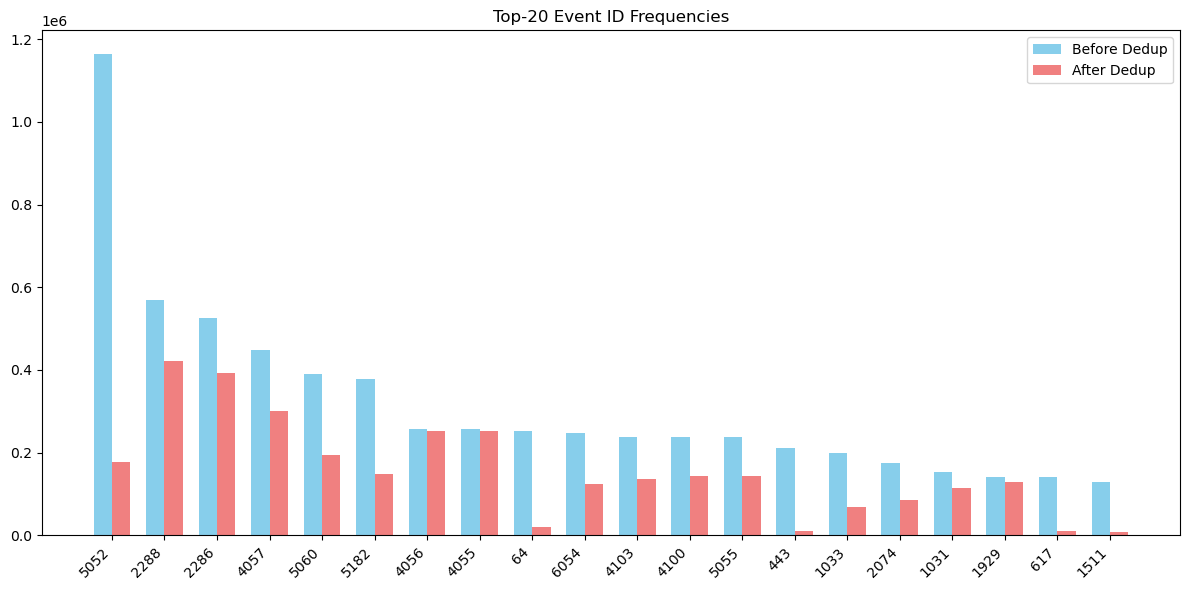

In [8]:
plot_top_n(tokenized_data, cleaned_ids)

In [9]:
import plotly.express as px
import pandas as pd

def plot_interactive(original_ids, cleaned_ids, n=50):
    # Get top-N IDs
    top_ids = [id_ for id_, _ in Counter(original_ids).most_common(n)]
    
    # Create DataFrame
    df = pd.DataFrame({
        'Event ID': top_ids,
        'Before Dedup': [Counter(original_ids).get(id_, 0) for id_ in top_ids],
        'After Dedup': [Counter(cleaned_ids).get(id_, 0) for id_ in top_ids]
    })
    
    # Melt for plotly
    df_melted = df.melt(id_vars='Event ID', var_name='Deduplication', value_name='Frequency')
    
    # Plot
    fig = px.bar(
        df_melted, 
        x='Event ID', 
        y='Frequency', 
        color='Deduplication',
        barmode='group',
        title=f'Top-{n} Event ID Frequencies'
    )
    fig.update_layout(xaxis_tickangle=-45)
    fig.show()

In [10]:
plot_interactive(tokenized_data, cleaned_ids, n=50)